# Test notebook

## 0. Basic imports

In [1]:
!nvidia-smi

Mon Jun 16 03:12:05 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     On   | 00000000:82:00.0 Off |                  N/A |
| 23%   29C    P8     8W / 250W |   1217MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [3]:
# fix randomness
torch.manual_seed(42)	
if device == "cuda:0":
	torch.cuda.manual_seed(42)
	torch.cuda.manual_seed_all(42)  # if you are using multi-GPU.
else:
	import random
	import numpy as np
	random.seed(42)
	np.random.seed(42)

In [4]:
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch

import numpy as np

from parse_config import ConfigParser
from utils import read_json
from utils.torchmath import ZennitHandler
from crp.image import imgify

from sklearn.metrics import mutual_info_score

In [5]:
def get_model(base_folder):
	json = base_folder + "/config.json"
	model_chpkt = base_folder + "/model_best.pth"
	json = read_json(json)

	config = ConfigParser(json, resume=model_chpkt)
	model = config.init_obj("arch", module_arch)
	# model = model.to(device)

	# load checkpoint
	checkpoint = base_folder + "/model_best.pth"
	print("Loading checkpoint: {} ...".format(checkpoint))
	checkpoint = torch.load(checkpoint, map_location=device, weights_only=False)
	model.load_state_dict(checkpoint["state_dict"])

	model.eval()

	for param in model.parameters():
		param.requires_grad = True # required in zennit

	model = model.to(device)

	return model

In [6]:
def get_dataloader(split: str = "test"):
	dataloader = module_data.JacobMedDataLoader(
		data_dir = "data/JacobMed",
		split = split,
		reduced_set = True,
		batch_size = 32,
		num_workers = 4
	)
	return dataloader

dataloader = get_dataloader("test")

In [ ]:
def evaluate(model, dataloader):

	total_loss = 0.0
	total_accuracy = 0.0
	# individual_losses = {}
	total_kl_div_dict = {}
	total_mi_dict = {}
	total_euclid_dict = {}
	# total_wass_dict = {}
	total_heatmaps = []
	
	n_samples = len(dataloader.dataset)

	# loss_fn = module_loss.XMILoss()
	
	print("Evaluating model on test set...")

	with torch.no_grad():
		for i, (data, target) in enumerate(dataloader):
			data = data.to(device)
			target = target.to(device)

			if type(model).__name__ == 'xMIEfficientNet':
				output, mi_layer_weights, features = model(data, output_features=True)
			else:
				output = model(data)

			# computing loss, metrics on test set

			batch_size = data.shape[0]
			total_accuracy += module_metric.accuracy(output, target) * batch_size

	# compute heatmaps

	print("Computing heatmaps...")
		
	zennit_handler = ZennitHandler(model)
	sample_input, sample_target = dataloader.dataset[0]
	sample_input = sample_input.to(device)
	layer_name = 'mi_layer.1' if type(model).__name__ == 'xMIEfficientNet' else 'features.8.0'
	attr, relevances = zennit_handler.get_attr_top(sample_input, layer_name, sample_target, k = 15)
	heatmap = attr.heatmap
	norm_heatmap = (heatmap - heatmap.mean()) / heatmap.std()
	total_heatmaps.append(heatmap)

	print("Computing metrics for heatmaps...")

	for k in [2, 5, 7, 10]:
		if k not in total_kl_div_dict:
			total_kl_div_dict[k] = 0.0
		total_kl_div_dict[k] += module_metric.kl_divergence_hm(norm_heatmap, k)

		if k not in total_euclid_dict:
			total_euclid_dict[k] = 0.0
		total_euclid_dict[k] += module_metric.euclidean_distance_hm(norm_heatmap, k)

		if k not in total_mi_dict:
			total_mi_dict[k] = 0.0
		
		# if k not in total_wass_dict:
		# 	total_wass_dict[k] = 0.0
		# total_wass_dict[k] += module_metric.wasserstein_hm(norm_heatmap, k)

	
	return {
		'accuracy': total_accuracy / n_samples,
		'loss': total_loss,
		# 'individual_losses': individual_losses,
		'kl_divergence': total_kl_div_dict,
		'euclidean_distance': total_euclid_dict,
		'heatmaps': total_heatmaps,
		# 'wasserstein_distance': total_wass_dict,
		'relevances': relevances,
	}

In [8]:
from matplotlib import pyplot as plt

def report_results(results):
	print("Results:")
	print(f"Accuracy: {results['accuracy']:.4f}")
	# print(f"Loss: {results['loss']:.4f}")
	
	for k, v in results['kl_divergence'].items():
		print(f"KL Divergence (k={k}): {v:.4f}")

	for k, v in results['euclidean_distance'].items():
		print(f"Euclidean Distance (k={k}): {v:.4f}")

	# for k, v in results['wasserstein_distance'].items():
	# 	print(f"Wasserstein Distance (k={k}): {v:.4f}")
	
	fig = imgify(results['heatmaps'][0], symmetric=True, grid=(2,5))
	fig.show()

	# KL divergence

	plt.figure(figsize=(10, 5))
	plt.bar(results['kl_divergence'].keys(), results['kl_divergence'].values())
	plt.xlabel('k')
	plt.ylabel('KL Divergence')
	plt.title('KL Divergence for different k values')
	plt.xticks(list(results['kl_divergence'].keys()))
	plt.show()

	# Euclidean distance

	plt.figure(figsize=(10, 5))
	plt.bar(results['euclidean_distance'].keys(), results['euclidean_distance'].values())
	plt.xlabel('k')
	plt.ylabel('Euclidean Distance')
	plt.title('Euclidean Distance for different k values')
	plt.xticks(list(results['euclidean_distance'].keys()))
	plt.show()

	# Wasserstein distance

	# plt.figure(figsize=(10, 5))
	# plt.bar(results['wasserstein_distance'].keys(), results['wasserstein_distance'].values())
	# plt.xlabel('k')
	# plt.ylabel('Wasserstein Distance')
	# plt.title('Wasserstein Distance for different k values')
	# plt.xticks(list(results['wasserstein_distance'].keys()))
	# plt.show()

	

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


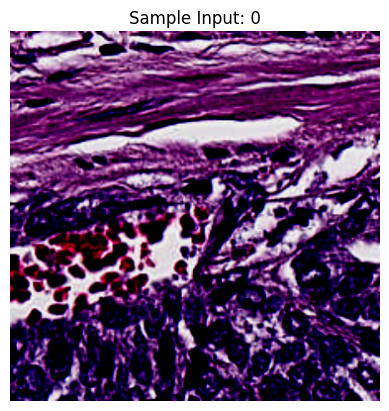

In [9]:
sample_input, sample_target = dataloader.dataset[0]

# visualize
plt.imshow(sample_input.permute(1, 2, 0).cpu().numpy())
plt.title(f"Sample Input: {sample_target}")
plt.axis('off')
plt.show()

## 1. Baseline

In [10]:
model_1 = get_model("saved/models/fCRP-prostate/0602_213033")
results_1 = evaluate(model_1, dataloader)

Loading checkpoint: saved/models/fCRP-prostate/0602_213033/model_best.pth ...
Evaluating model on test set...
Computing heatmaps...
Computing metrics for heatmaps...


/mnt/homeGPU/sjhu/conda_env/crp/lib/python3.9/site-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Results:
Accuracy: 0.8238
KL Divergence (k=2): nan
KL Divergence (k=5): nan
KL Divergence (k=7): nan
KL Divergence (k=10): nan
Euclidean Distance (k=2): 831.8989
Euclidean Distance (k=5): 407.5607
Euclidean Distance (k=7): 438.1043
Euclidean Distance (k=10): 409.5536


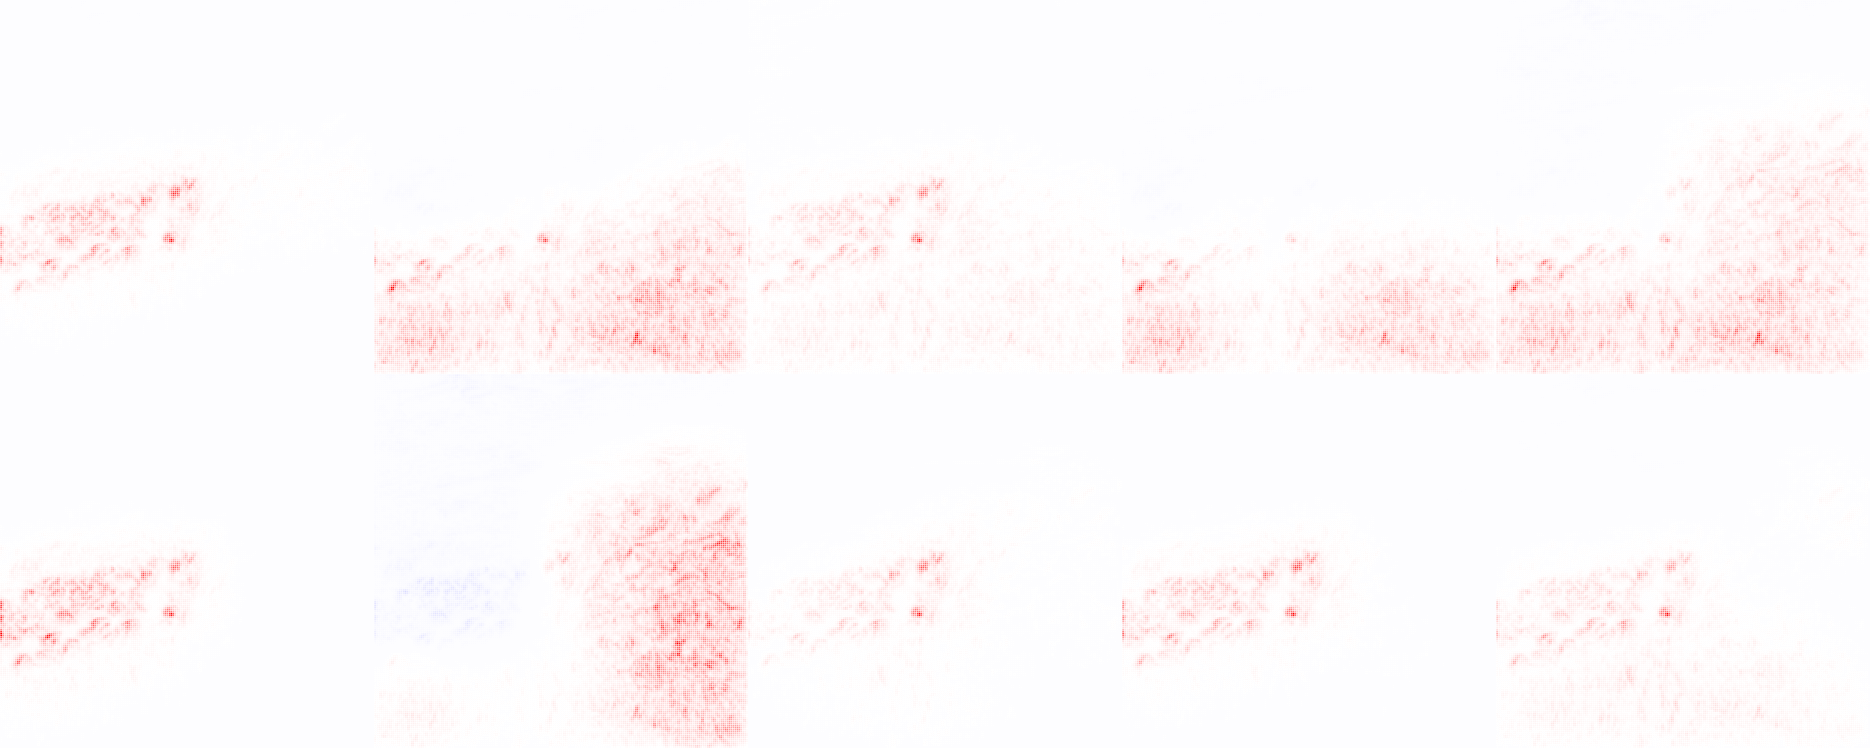

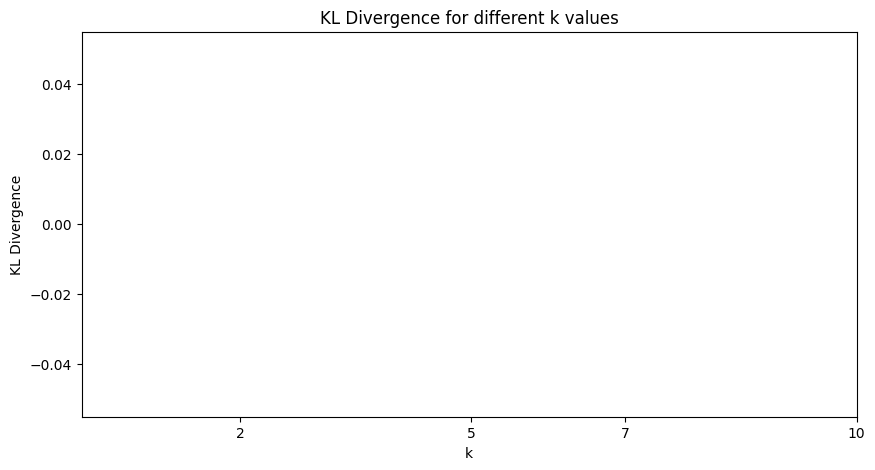

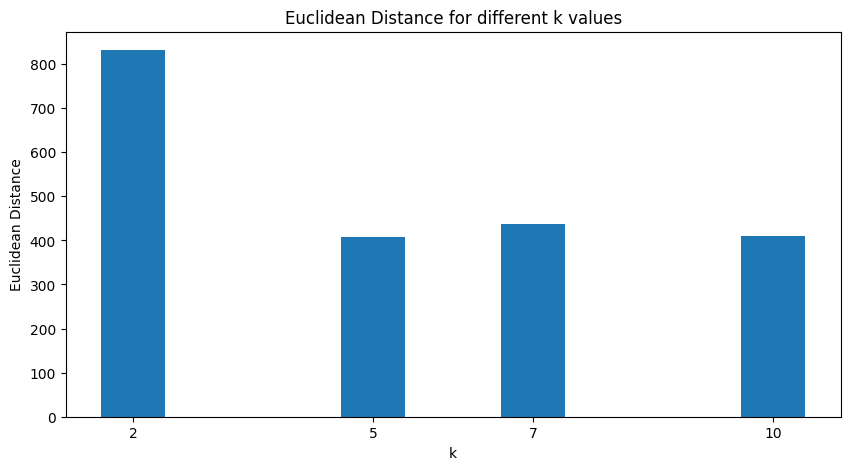

In [11]:
report_results(results_1)

In [12]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## 2. xMI-EfficientNet(-l2)

In [13]:
model_2 = get_model("saved/models/xMI-Efficient/0609_084216")
results_2 = evaluate(model_2, dataloader)

Loading checkpoint: saved/models/xMI-Efficient/0609_084216/model_best.pth ...
Evaluating model on test set...
Computing heatmaps...
Computing metrics for heatmaps...


Results:
Accuracy: 0.7667
KL Divergence (k=2): nan
KL Divergence (k=5): nan
KL Divergence (k=7): nan
KL Divergence (k=10): nan
Euclidean Distance (k=2): 290.6903
Euclidean Distance (k=5): 327.2192
Euclidean Distance (k=7): 313.2377
Euclidean Distance (k=10): 439.5087


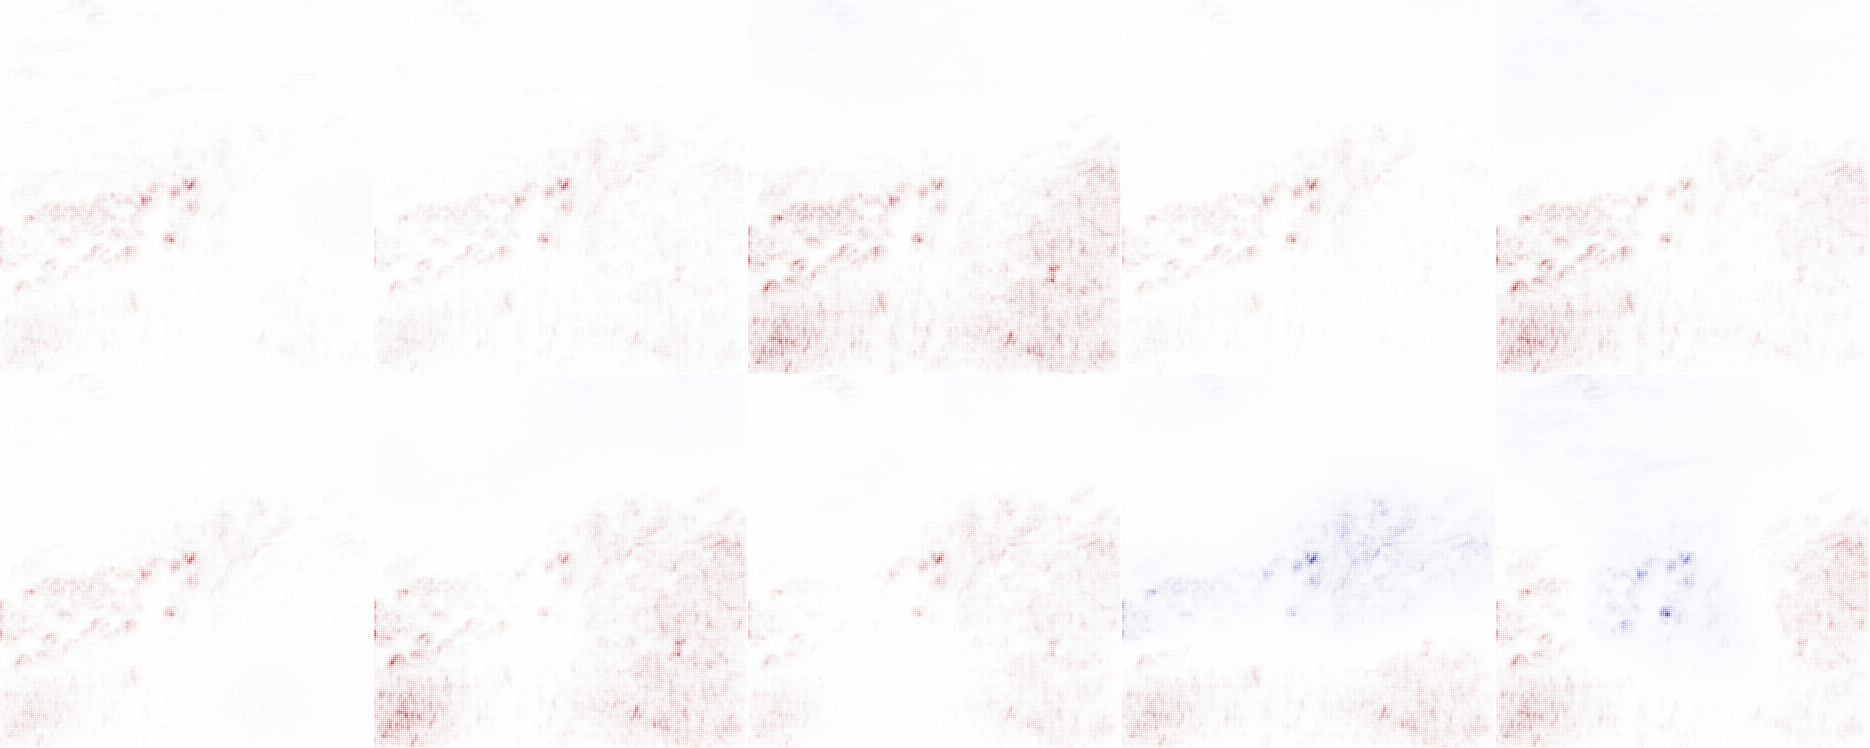

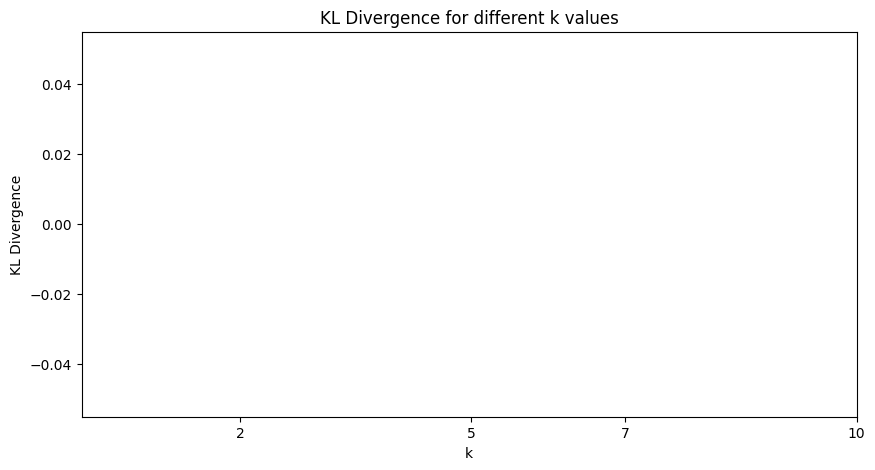

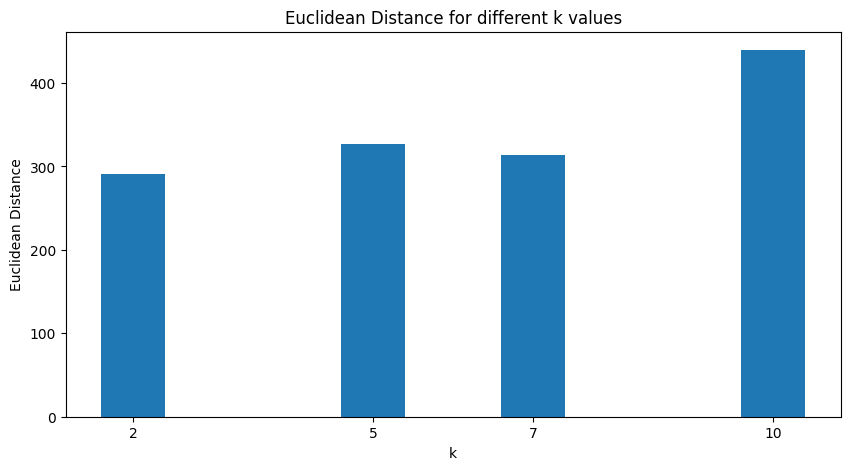

In [14]:
report_results(results_2)

In [15]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## 3. xMI-EFfficientNet(-ortho)

In [16]:
model_3 = get_model("saved/models/xMI-Efficient/0609_084016")
results_3 = evaluate(model_3, dataloader)

Loading checkpoint: saved/models/xMI-Efficient/0609_084016/model_best.pth ...
Evaluating model on test set...
Computing heatmaps...
Computing metrics for heatmaps...


Results:
Accuracy: 0.7762
KL Divergence (k=2): nan
KL Divergence (k=5): nan
KL Divergence (k=7): nan
KL Divergence (k=10): nan
Euclidean Distance (k=2): 573.3953
Euclidean Distance (k=5): 533.2671
Euclidean Distance (k=7): 488.4560
Euclidean Distance (k=10): 454.7709


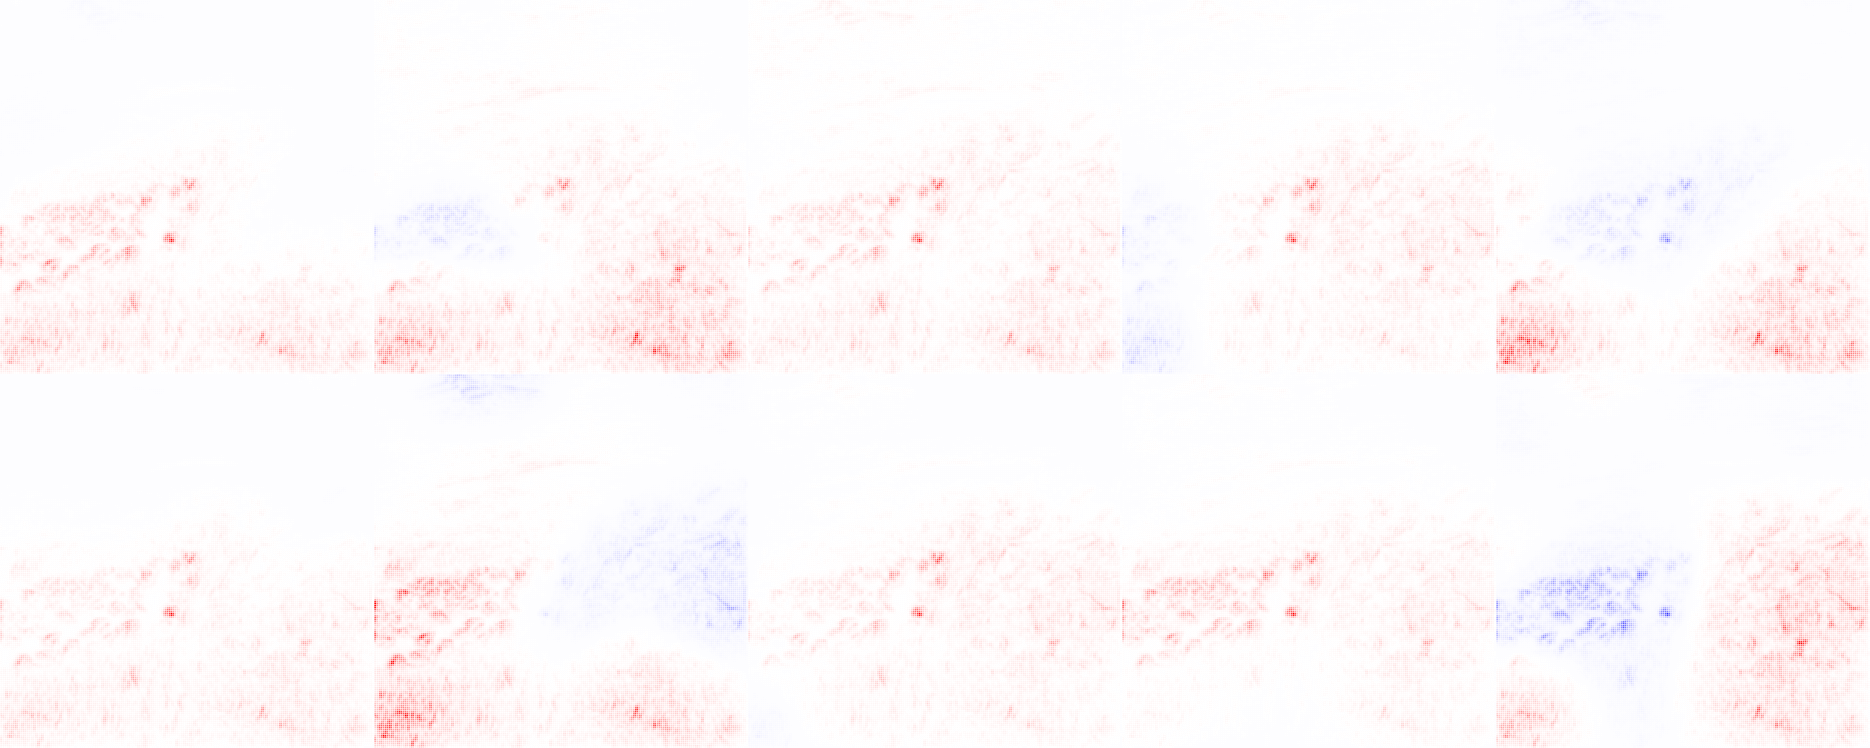

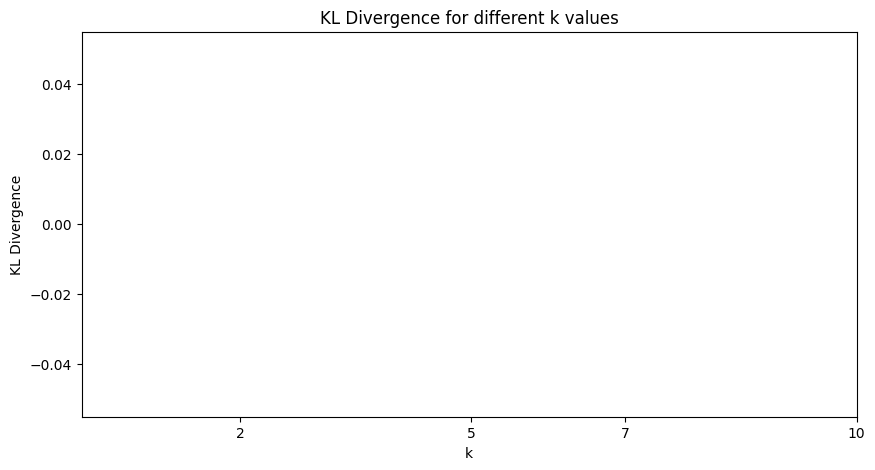

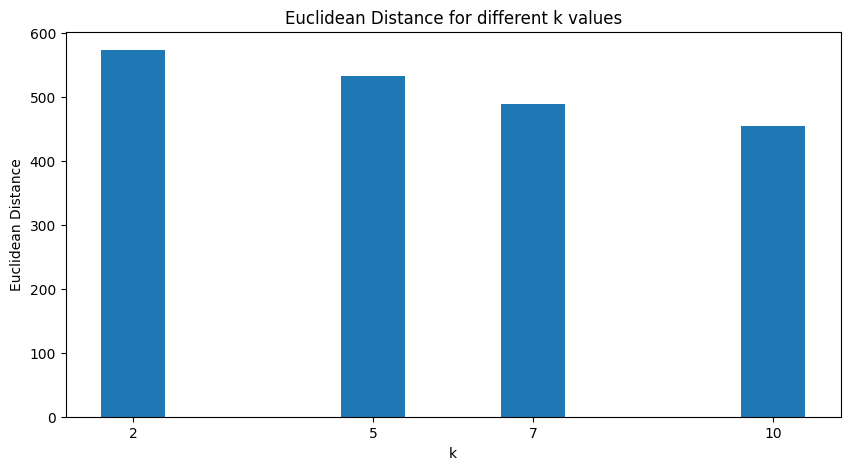

In [17]:
report_results(results_3)

In [18]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## Z. xMI-EfficientNet

In [19]:
model_z = get_model("saved/models/xMI-Efficient/0607_173559")
results_z = evaluate(model_z, dataloader)

Loading checkpoint: saved/models/xMI-Efficient/0607_173559/model_best.pth ...
Evaluating model on test set...
Computing heatmaps...
Computing metrics for heatmaps...


/mnt/homeGPU/sjhu/conda_env/crp/lib/python3.9/site-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Results:
Accuracy: 0.8381
KL Divergence (k=2): nan
KL Divergence (k=5): nan
KL Divergence (k=7): nan
KL Divergence (k=10): nan
Euclidean Distance (k=2): 662.7593
Euclidean Distance (k=5): 471.5328
Euclidean Distance (k=7): 465.2578
Euclidean Distance (k=10): 450.8053


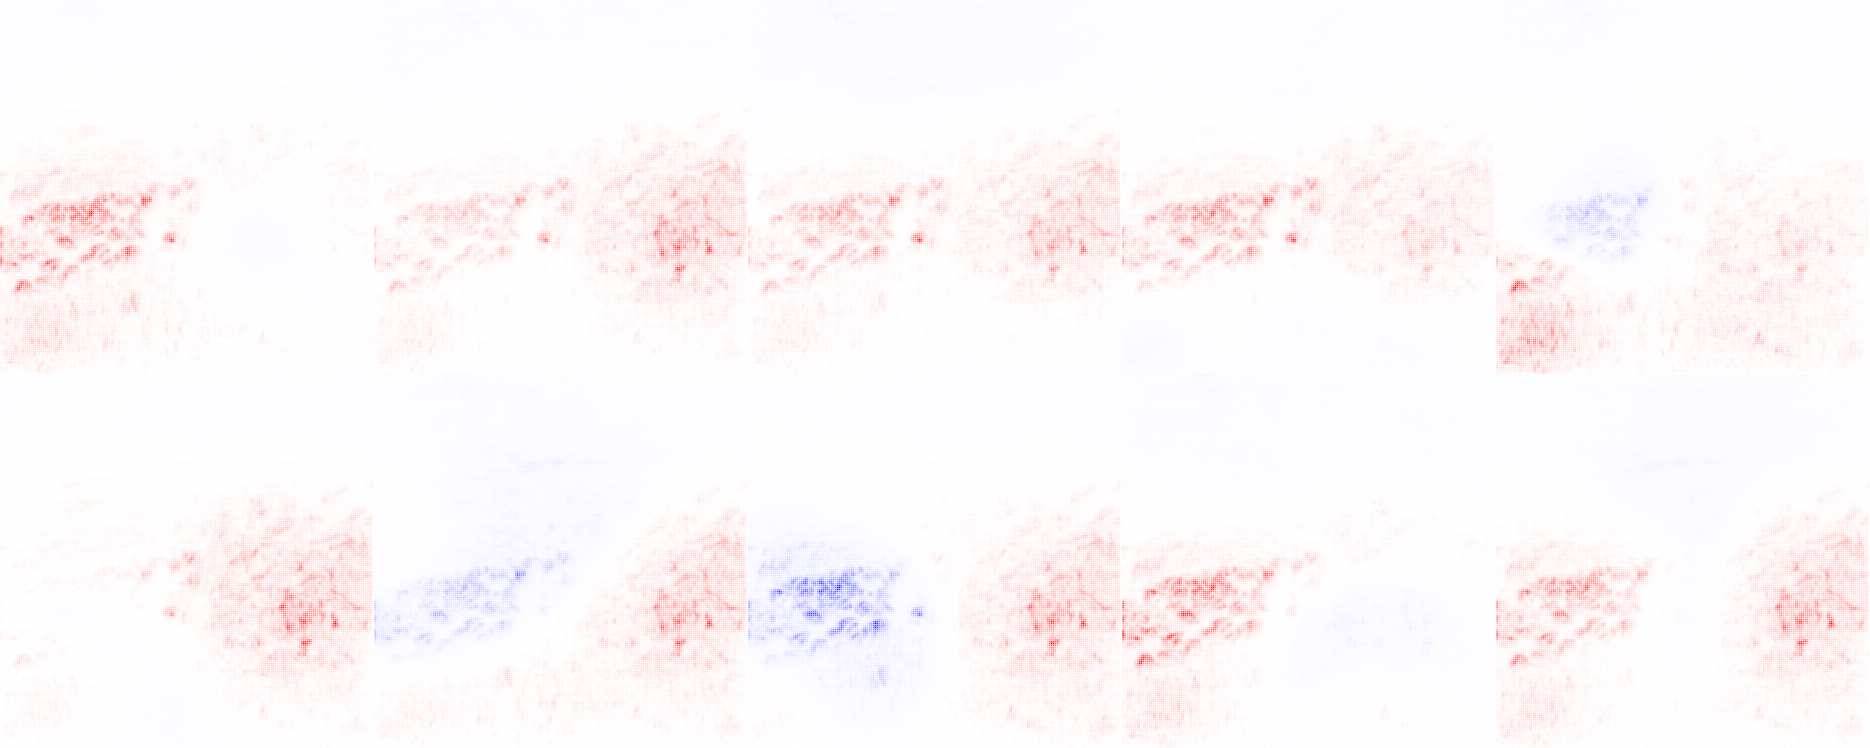

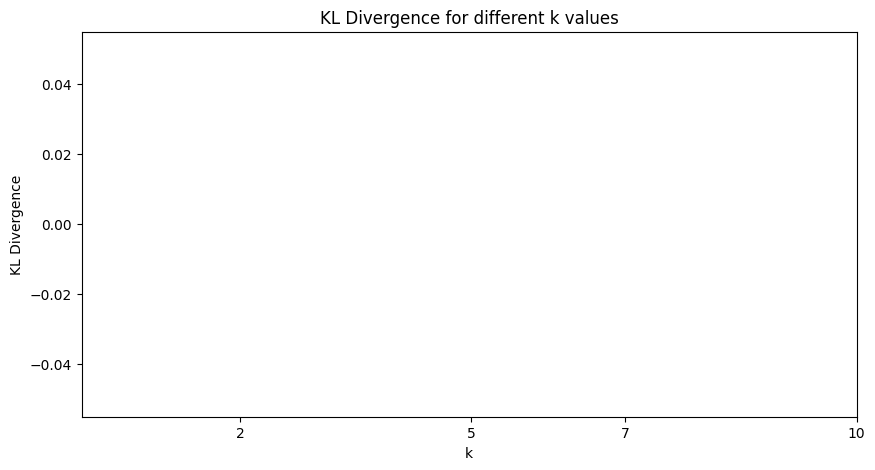

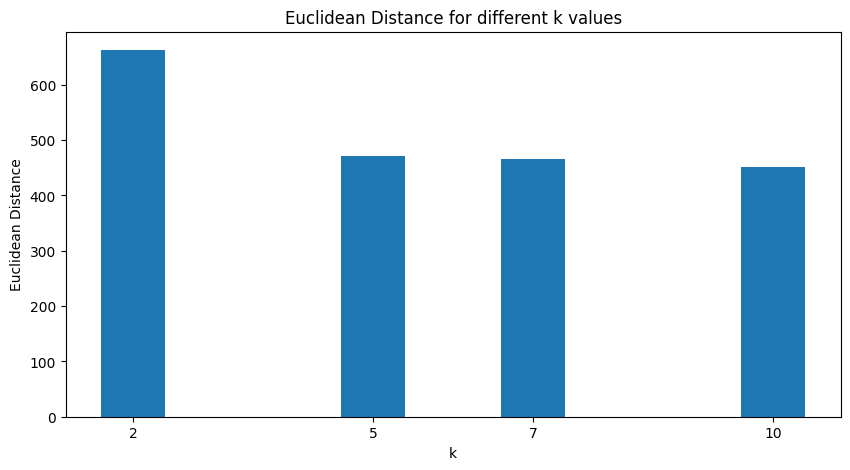

In [20]:
report_results(results_z)

In [21]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

## FINAL. Comparison between models

In [22]:
import pandas as pd
pd.set_option('display.width', 300)

In [23]:
def report_comparison(*results):
	# accuracy comparison (does not depend on k)

	print("Accuracy Comparison:")
	for res, name in results:
		print(f"{name}: {res['accuracy']:.4f}")

	# graphical comparison of results in KL divergence
	plt.figure(figsize=(10, 5))
	n_models = len(results)
	bar_width = 0.8 / n_models
	ks = list(results[0][0]['kl_divergence'].keys())
	x = np.arange(len(ks))
	for i, (res, name) in enumerate(results):
		plt.bar(x + i * bar_width, list(res['kl_divergence'].values()), width=bar_width, label=name)
	plt.xlabel('k')
	plt.ylabel('KL Divergence')
	plt.title('KL Divergence for different k values')
	plt.xticks(x + bar_width * (n_models - 1) / 2, ks)
	plt.legend()
	plt.show()

	# graphical comparison of results in Euclidean distance
	plt.figure(figsize=(10, 5))
	ks = list(results[0][0]['euclidean_distance'].keys())
	x = np.arange(len(ks))
	for i, (res, name) in enumerate(results):
		plt.bar(x + i * bar_width, list(res['euclidean_distance'].values()), width=bar_width, label=name)
	plt.xlabel('k')
	plt.ylabel('Euclidean Distance')
	plt.title('Euclidean Distance for different k values')
	plt.xticks(x + bar_width * (n_models - 1) / 2, ks)
	plt.legend()
	plt.show()

	# graphical comparison of results in Wasserstein distance
	# plt.figure(figsize=(10, 5))
	# ks = list(results[0][0]['wasserstein_distance'].keys())
	# x = np.arange(len(ks))
	# for i, (res, name) in enumerate(results):
	# 	plt.bar(x + i * bar_width, list(res['wasserstein_distance'].values()), width=bar_width, label=name)
	# plt.xlabel('k')
	# plt.ylabel('Wasserstein Distance')
	# plt.title('Wasserstein Distance for different k values')
	# plt.xticks(x + bar_width * (n_models - 1) / 2, ks)
	# plt.legend()
	# plt.show()

	# print in table format results using pandas
	# --- KL divergence columns are commented out below ---
	data = {
		'Model': [],
		'Accuracy': [],
		# 'KL (k=2)': [],
		# 'KL (k=5)': [],
		# 'KL (k=7)': [],
		# 'KL (k=10)': [],
		'Euclid(k=2)': [],
		'Euclid(k=5)': [],
		'Euclid(k=7)': [],
		'Euclid(k=10)': [],
		# 'Wasserstein (k=2)': [],
		# 'Wasserstein (k=5)': [],
		# 'Wasserstein (k=7)': [],
		# 'Wasserstein (k=10)': []
	}
	for res, name in results:
		data['Model'].append(name)
		data['Accuracy'].append(res['accuracy'])
		# for k, v in res['kl_divergence'].items():
		# 	data[f'KL (k={k})'] = data.get(f'KL Divergence (k={k})', [])
		for k, v in res['euclidean_distance'].items():
			data[f'Euclid(k={k})'] = data.get(f'Euclidean Distance (k={k})', [])
		# for k, v in res['wasserstein_distance'].items():
		# 	data[f'Wasserstein (k={k})'] = data.get(f'Wasserstein Distance (k={k})', [])

	for res, name in results:
		# for k, v in res['kl_divergence'].items():
		# 	data[f'KL (k={k})'].append(v)
		for k, v in res['euclidean_distance'].items():
			data[f'Euclid(k={k})'].append(v)
		# for k, v in res['wasserstein_distance'].items():
		# 	data[f'Wasserstein (k={k})'].append(v)
	df = pd.DataFrame(data)
	print("\nComparison Results:")
	print(df)

	# convert to latex table. highlight for each column the best value, round to 3 decimals

	def highlight_best_second_latex_color(df, color_best='yellow', color_second='blue'):
		df = df.copy()
		# Only highlight 'Accuracy' (higher is better) and 'Euclid(k=...)' (higher is better)
		cols_to_highlight = ['Accuracy'] + [col for col in df.columns if col.startswith('Euclid(k=')]
		for col in cols_to_highlight:
			vals = df[col].astype(float)
			# Get indices of two highest values
			order = vals.argsort()
			best = order[0]
			second = order[1]
			df.loc[best, col] = f"\\color{{{color_best}}} {vals.iloc[best]:.3f}"
			df.loc[second, col] = f"\\color{{{color_second}}} {vals.iloc[second]:.3f}"
			for i in range(len(vals)):
				if i != best and i != second:
					df.loc[i, col] = f"{vals.iloc[i]:.3f}"
		# Format all numeric columns to 3 decimals if not already colored
		for col in cols_to_highlight:
			df[col] = df[col].apply(lambda x: f"{float(x):.3f}" if not isinstance(x, str) or not x.startswith("\\color") else x)
		latex = df.to_latex(index=True, escape=False)
		return latex


	latex_table = highlight_best_second_latex_color(df)
	print("\nLatex Table:")
	print(latex_table)


Accuracy Comparison:
fCRP-prostate(base): 0.8238
xMI-Efficient(-l2): 0.7667
xMI-Efficient(-ortho): 0.7762
xMI-Efficient(ours): 0.8381


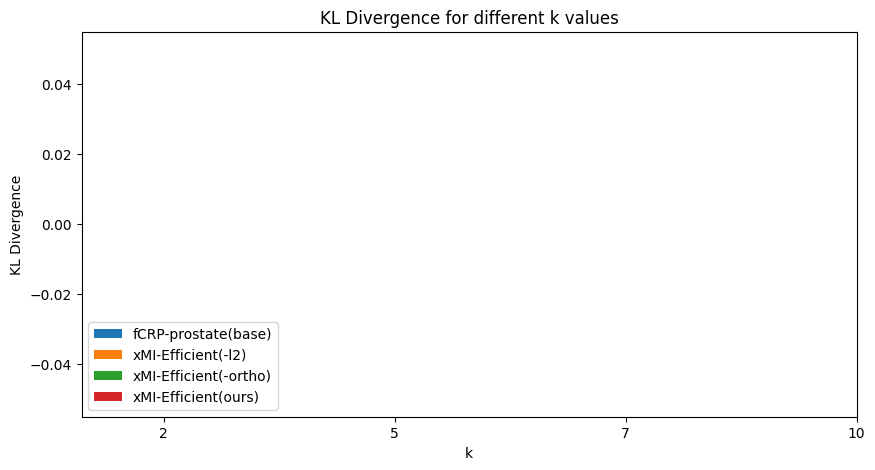

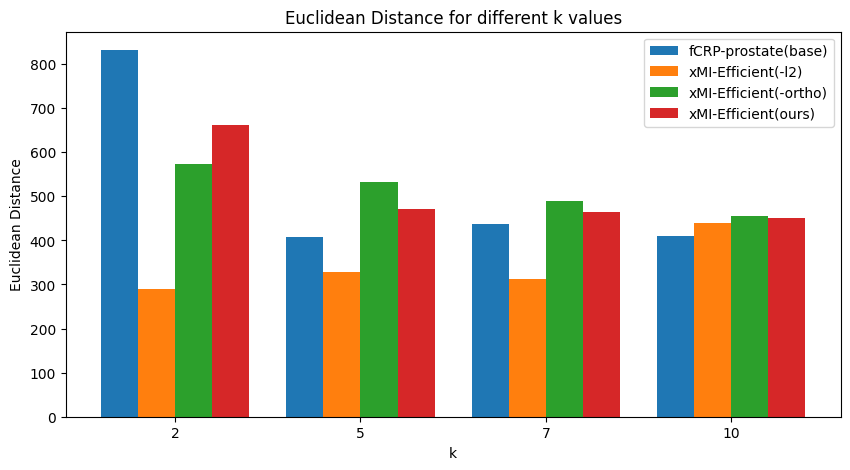


Comparison Results:
                   Model  Accuracy  Euclid(k=2)  Euclid(k=5)  Euclid(k=7)  Euclid(k=10)
0    fCRP-prostate(base)  0.823810   831.898865   407.560684   438.104292    409.553628
1     xMI-Efficient(-l2)  0.766667   290.690277   327.219217   313.237673    439.508726
2  xMI-Efficient(-ortho)  0.776190   573.395325   533.267142   488.456032    454.770928
3    xMI-Efficient(ours)  0.838095   662.759338   471.532774   465.257798    450.805270

Latex Table:
\begin{tabular}{lllllll}
\toprule
 & Model & Accuracy & Euclid(k=2) & Euclid(k=5) & Euclid(k=7) & Euclid(k=10) \\
\midrule
0 & fCRP-prostate(base) & 0.824 & 831.899 & \color{blue} 407.561 & \color{blue} 438.104 & \color{yellow} 409.554 \\
1 & xMI-Efficient(-l2) & \color{yellow} 0.767 & \color{yellow} 290.690 & \color{yellow} 327.219 & \color{yellow} 313.238 & \color{blue} 439.509 \\
2 & xMI-Efficient(-ortho) & \color{blue} 0.776 & \color{blue} 573.395 & 533.267 & 488.456 & 454.771 \\
3 & xMI-Efficient(ours) & 0.838 & 66

/tmp/ipykernel_37320/2452098812.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\color{yellow} 0.767' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[best, col] = f"\\color{{{color_best}}} {vals.iloc[best]:.3f}"
/tmp/ipykernel_37320/2452098812.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\color{yellow} 290.690' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[best, col] = f"\\color{{{color_best}}} {vals.iloc[best]:.3f}"
/tmp/ipykernel_37320/2452098812.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\color{yellow} 327.219' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[best,

In [24]:
report_comparison(
	(results_1, "fCRP-prostate(base)"), 
	(results_2, "xMI-Efficient(-l2)"),
	(results_3, "xMI-Efficient(-ortho)"),
	(results_z, "xMI-Efficient(ours)")
)

In [25]:
def show_hm(hm, img, save_path=None):
	"""
	Displays a heatmap overlay on the original image.
	Args:
		hm (torch.Tensor): The heatmap tensor (C, H, W).
		img (torch.Tensor): The original image tensor (C, H, W).
		save_path (str, optional): Path to save the figure.
	"""
	norm_hm = (hm - hm.min()) / (hm.max() - hm.min())
	norm_hm = norm_hm.cpu().numpy()
	norm_hm[norm_hm < 0.1] = 0 # clearer visualization

	# Show heatmap
	plt.figure(figsize=(6,6))
	plt.imshow(img.permute(1, 2, 0).cpu().numpy(), alpha=0.9)
	plt.imshow(norm_hm, cmap='hot', vmin=0, alpha=0.5)
	plt.axis('off')
	if save_path:
		plt.savefig(save_path, format='pdf')
	else:
		plt.show()

In [26]:
h1 = results_z['heatmaps'][0][0]
h2 = results_z['heatmaps'][0][1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


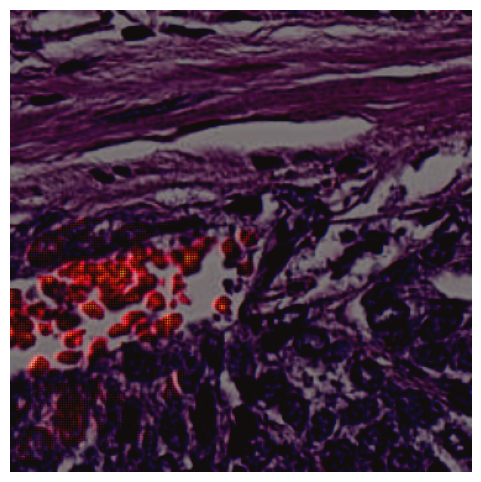

In [42]:
show_hm(h1, sample_input, save_path="tmp/hm1.pdf")

In [28]:
norm_h1 = (h1 - h1.min()) / (h1.max() - h1.min())
norm_h2 = (h2 - h2.min()) / (h2.max() - h2.min())

In [29]:
norm_h1

tensor([[0.0171, 0.0167, 0.0174,  ..., 0.0177, 0.0177, 0.0177],
        [0.0167, 0.0162, 0.0172,  ..., 0.0177, 0.0177, 0.0177],
        [0.0174, 0.0172, 0.0175,  ..., 0.0177, 0.0177, 0.0177],
        ...,
        [0.0367, 0.0531, 0.0341,  ..., 0.0182, 0.0179, 0.0179],
        [0.0258, 0.0347, 0.0266,  ..., 0.0179, 0.0178, 0.0178],
        [0.0258, 0.0347, 0.0266,  ..., 0.0179, 0.0178, 0.0178]],
       device='cuda:0')

In [30]:
norm_h1_np = norm_h1.cpu().numpy() if hasattr(norm_h1, 'cpu') else norm_h1

print("Media:", np.mean(norm_h1_np))
print("Desviación estándar:", np.std(norm_h1_np))
print("Mínimo:", np.min(norm_h1_np))
print("Máximo:", np.max(norm_h1_np))
print("Mediana:", np.median(norm_h1_np))
print("Percentil 25:", np.percentile(norm_h1_np, 25))
print("Percentil 75:", np.percentile(norm_h1_np, 75))

Media: 0.04110893
Desviación estándar: 0.051432617
Mínimo: 0.0
Máximo: 1.0
Mediana: 0.024866205
Percentil 25: 0.019423157
Percentil 75: 0.0397826


In [31]:
# idem para norm_h2
norm_h2_np = norm_h2.cpu().numpy() if hasattr(norm_h2, 'cpu') else norm_h2

print("Media:", np.mean(norm_h2_np))
print("Desviación estándar:", np.std(norm_h2_np))
print("Mínimo:", np.min(norm_h2_np))
print("Máximo:", np.max(norm_h2_np))
print("Mediana:", np.median(norm_h2_np))
print("Percentil 25:", np.percentile(norm_h2_np, 25))
print("Percentil 75:", np.percentile(norm_h2_np, 75))

Media: 0.05387217
Desviación estándar: 0.04669052
Mínimo: 0.0
Máximo: 1.0
Mediana: 0.037314683
Percentil 25: 0.029534355
Percentil 75: 0.057931382


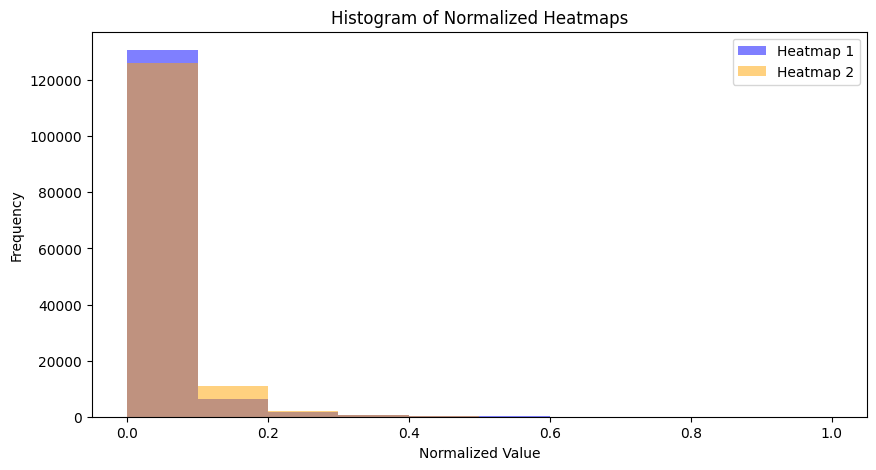

In [32]:
# mostrar histograma
plt.figure(figsize=(10, 5))
plt.hist(norm_h1_np.flatten(), alpha=0.5, label='Heatmap 1', color='blue')
plt.hist(norm_h2_np.flatten(), alpha=0.5, label='Heatmap 2', color='orange')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.title('Histogram of Normalized Heatmaps')
plt.legend()
plt.show()

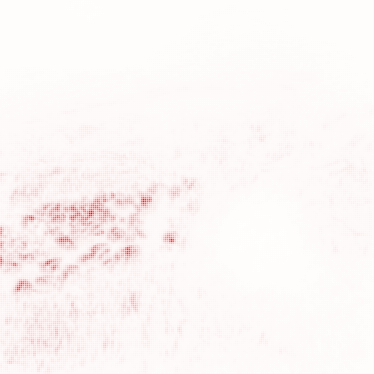

In [33]:
imgify(norm_h1, symmetric=True).show()
# imgify(norm_h2, symmetric=True).show()

In [34]:
norm_h1.max()

tensor(1., device='cuda:0')

In [35]:
norm_h1_np_clean = norm_h1_np
norm_h1_np_clean[norm_h1_np_clean < 0.1] = 0

# masked_h1 = np.ma.masked_where(norm_h1_np_clean < 0.1, norm_h1_np_clean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..1.0].


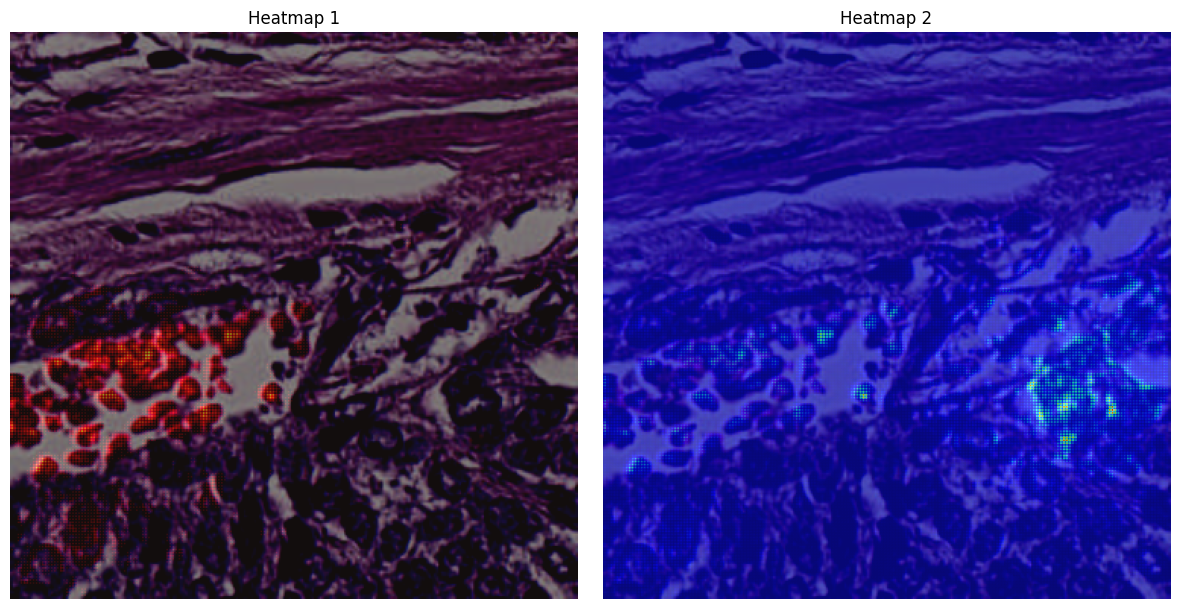

In [36]:
# plot heatmaps with images as background
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(sample_input.permute(1, 2, 0).cpu().numpy(), alpha=0.9)
ax[0].imshow(norm_h1_np_clean, cmap='hot', vmin=0, alpha=0.5)
ax[0].set_title('Heatmap 1')
ax[0].axis('off')
ax[1].imshow(sample_input.permute(1, 2, 0).cpu().numpy(), alpha=0.9)
ax[1].imshow(norm_h2_np, cmap='jet', alpha=0.7)
ax[1].set_title('Heatmap 2')
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [37]:
results_1['heatmaps'][0]

tensor([[[-2.5450e-18, -3.7795e-18, -1.2346e-18,  ..., -9.2396e-19,
          -2.8992e-19, -2.8992e-19],
         [-3.7979e-18, -5.6148e-18, -1.8169e-18,  ..., -1.8808e-18,
          -5.7832e-19, -5.7832e-19],
         [-1.2529e-18, -1.8353e-18, -5.8239e-19,  ..., -9.5686e-19,
          -2.8839e-19, -2.8839e-19],
         ...,
         [ 4.2123e-18,  7.2781e-18,  3.0658e-18,  ..., -4.9751e-20,
          -1.9995e-20, -1.9995e-20],
         [ 1.8577e-18,  3.3419e-18,  1.4842e-18,  ..., -1.7733e-20,
          -7.7989e-21, -7.7989e-21],
         [ 1.8577e-18,  3.3419e-18,  1.4842e-18,  ..., -1.7733e-20,
          -7.7989e-21, -7.7989e-21]],

        [[-2.0225e-19, -3.0049e-19, -9.8243e-20,  ..., -8.3582e-19,
          -2.6256e-19, -2.6256e-19],
         [-3.0221e-19, -4.4709e-19, -1.4487e-19,  ..., -1.6944e-18,
          -5.2127e-19, -5.2127e-19],
         [-9.9964e-20, -1.4659e-19, -4.6629e-20,  ..., -8.5860e-19,
          -2.5871e-19, -2.5871e-19],
         ...,
         [ 5.6217e-17,  9

In [38]:
# import again module_metric with new functions. use importlib
import importlib
importlib.reload(module_metric)

<module 'model.metric' from '/mnt/homeGPU/sjhu/workspace/fCRP-EfficientNet/model/metric.py'>

In [39]:
module_metric.wasserstein_hm(results_1['heatmaps'][0], k=3)

np.float64(3.086602025581668e-06)

In [40]:
module_metric.wasserstein_hm(results_2['heatmaps'][0], k=3)

np.float64(1.6806666591603335e-06)

In [41]:
heatmaps = results_1['heatmaps'][0].cpu().numpy()